In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels as sm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [250]:
train = pd.read_csv("/Users/karnavivek/Downloads/Food Demand/data/train.csv")
meal_info = pd.read_csv("/Users/karnavivek/Downloads/Food Demand/data/meal_info.csv")
fulfilment_center_info = pd.read_csv("/Users/karnavivek/Downloads/Food Demand/data/fulfilment_center_info.csv")
test = pd.read_csv("/Users/karnavivek/Downloads/Food Demand/data/test.csv")

merge1 = pd.merge(train, fulfilment_center_info, how='left')
merge2 = pd.merge(merge1, meal_info, how='left')

merge2[['center_id', 'meal_id', 'emailer_for_promotion', 'homepage_featured']] = merge2[['center_id', 'meal_id', 'emailer_for_promotion', 'homepage_featured']].astype('object')

df_weekly_orders = merge2.groupby(['week'])['num_orders'].sum().reset_index()
df_weekly_orders.set_index(df_weekly_orders['week'], inplace=True)
df_weekly_orders.drop(columns='week', inplace=True)

In [273]:
train_orders  = df_weekly_orders [:110]
test_orders = df_weekly_orders[110:]
train_orders.shape, test_orders.shape

((110, 1), (35, 1))

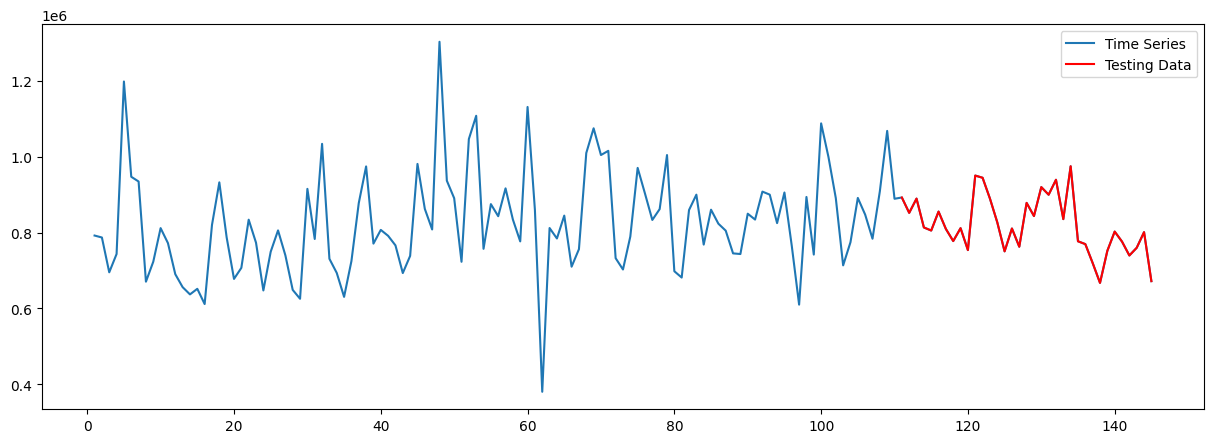

In [274]:
plt.figure(figsize=(15,5))
plt.plot(df_weekly_orders['num_orders'], label = 'Time Series')
plt.plot(test_orders, color='red', label='Testing Data')
plt.legend()
plt.show()

In [275]:
df_weekly_orders

,num_orders
week,
1,792261
2,787084
3,695262
4,743529
5,1198675
...,...
141,776240
142,739661
143,759926


In [276]:
''' Scale the data - (0, 1)'''
scaler = MinMaxScaler(feature_range=(0, 1))

train_orders = scaler.fit_transform(train_orders)
test_orders  = scaler.fit_transform(test_orders)

In [277]:
#shape of the datasets
print(f'Shape of Training set: {train_orders.shape}')
print(f'Shape of Testing set : {test_orders.shape}')

Shape of Training set: (110, 1)
Shape of Testing set : (35, 1)


In [295]:
'''Let's Create Dataset for LSTM model, i.e. converting time series into inputs and labele'''
def create_dataset(df, lookback):
    X_data, y_data = [], []

    for i in range(lookback, len(df)):
        X_data.append(df[i-lookback:i, 0])
        y_data.append(df[i,0])

    return np.array(X_data), np.array(y_data)

lookback = 25
X_train, y_train = create_dataset(train_orders, lookback)
X_test, y_test = create_dataset(test_orders, lookback)


In [296]:
print("Shape of train input: " + str(X_train.shape))
print("Shape of train labels: " + str(y_train.shape))
print("Shape of test input: " + str(X_test.shape))
print("Shape of test labels: " + str(y_test.shape))

Shape of train input: (85, 25)
Shape of train labels: (85,)
Shape of test input: (10, 25)
Shape of test labels: (10,)


In [297]:
'''Reshaping the data to tensorflow can understand'''

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print("Shape of train input: " + str(X_train.shape))
print("Shape of train labels: " + str(y_train.shape))
print("Shape of test input: " + str(X_test.shape))
print("Shape of test labels: " + str(y_test.shape))

Shape of train input: (85, 1, 25)
Shape of train labels: (85,)
Shape of test input: (10, 1, 25)
Shape of test labels: (10,)


In [298]:
'''Creating LSTM Model using keras'''

model = Sequential()
model.add(LSTM(64, input_shape = (1, lookback)))
# model.add(LSTM(32, input_shape = (1, lookback)))
model.add(Dense(8,'relu'))
model.add(Dense(1, 'linear'))
model.compile(loss = 'mean_squared_error', optimizer='adam')

In [282]:
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 64)             │        21,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,289 (87.07 KB)

 Trainable params: 22,289 (87.07 KB)

 Non-trainable params: 0 (0.00 B)

In [153]:
'''lets visualize it'''
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

def plot_tf_model(model, show_shapes=True, show_layers_names=True):
    return SVG(model_to_dot(model, show_shapes=show_shapes, show_layers_names=show_layers_names).create(prog='dot',format='svg'))

plot_tf_model(model, show_shapes=True, show_layers_names=False)

ImportError: You must install pydot (`pip install pydot`) for model_to_dot to work.

In [299]:
model.fit(X_train, y_train, epochs=300, batch_size=1, verbose=1)

Epoch 1/300
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 0.0857 
Epoch 2/300
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 0.0223
Epoch 3/300
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 0.0238  
Epoch 4/300
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 0.0209
Epoch 5/300
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 0.0192  
Epoch 6/300
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 0.0202
Epoch 7/300
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 0.0313
Epoch 8/300
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 0.0221  
Epoch 9/300
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 0.0184
Epoch 10/300
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 0.0314
Epoch 11/300
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 0.0182
Epoch 12/300
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 0.0126  
Epoch 13/300
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 0.0381
Epoch 14/300
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 0.0140
Epoch 15/300
85/85 ━━━━━━━━━━━━━━━

In [300]:
'''Lets predict now'''

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [301]:
y_test.shape

(10,)

In [302]:
'''Inverse Transforming the data'''
train_pred = scaler.inverse_transform(train_pred)
y_train = scaler.inverse_transform([y_train])

test_pred = scaler.inverse_transform(test_pred)
y_test = scaler.inverse_transform([y_test])

In [303]:
y_train[0]

array([809224.82750121, 787299.36286756, 756922.44160443, 749107.84355615,
       845748.05060256, 801696.16595877, 885340.25888139, 784274.03466242,
       771832.4640651 , 750788.80362078, 782250.81726504, 833235.49576778,
       865466.0054289 , 797613.73915628, 809676.06063514, 804455.21995859,
       796055.75178472, 771721.82196727, 786822.46876516, 867676.51457019,
       828158.95638147, 810045.97849234, 975072.        , 852940.12022088,
       837542.87261856, 781641.28594898, 889542.32578363, 910012.78017895,
       793049.41936144, 832333.02949993, 821703.72314358, 846188.6194379 ,
       818769.37473576, 799552.30868364, 917752.06161847, 827320.80916447,
       667343.        , 811314.36350542, 802127.40353284, 822243.27000017,
       777324.57783693, 792720.49240193, 877266.0518144 , 898999.22581417,
       875491.44587781, 879182.95948525, 784812.24848168, 774856.79249225,
       803821.36071138, 864197.62041581, 841591.97348797, 818419.11917907,
       827962.33337629, 8

In [304]:
train_score = np.sqrt(mean_squared_error(y_train[0], train_pred[:,0]))
print('Train Score: %.2f RMSE' % (train_score))
test_score = np.sqrt(mean_squared_error(y_test[0], test_pred[:,0]))
print('Test Score: %.2f RMSE' % (test_score))

Train Score: 8716.03 RMSE
Test Score: 118170.29 RMSE


In [305]:
X_train.shape, X_test.shape, y_train[0].shape, train_pred[:,0].shape, y_test[0].shape, test_pred[:,0].shape

((85, 1, 25), (10, 1, 25), (85,), (85,), (10,), (10,))

In [306]:
week_train = list(range(1, len(X_train)+1))
week_train

trainActual = pd.DataFrame({'Number of Orders':y_train[0]})
trainActual.index = week_train

trainPred = pd.DataFrame({'Number of Orders': train_pred[:,0]})
trainPred.index = week_train

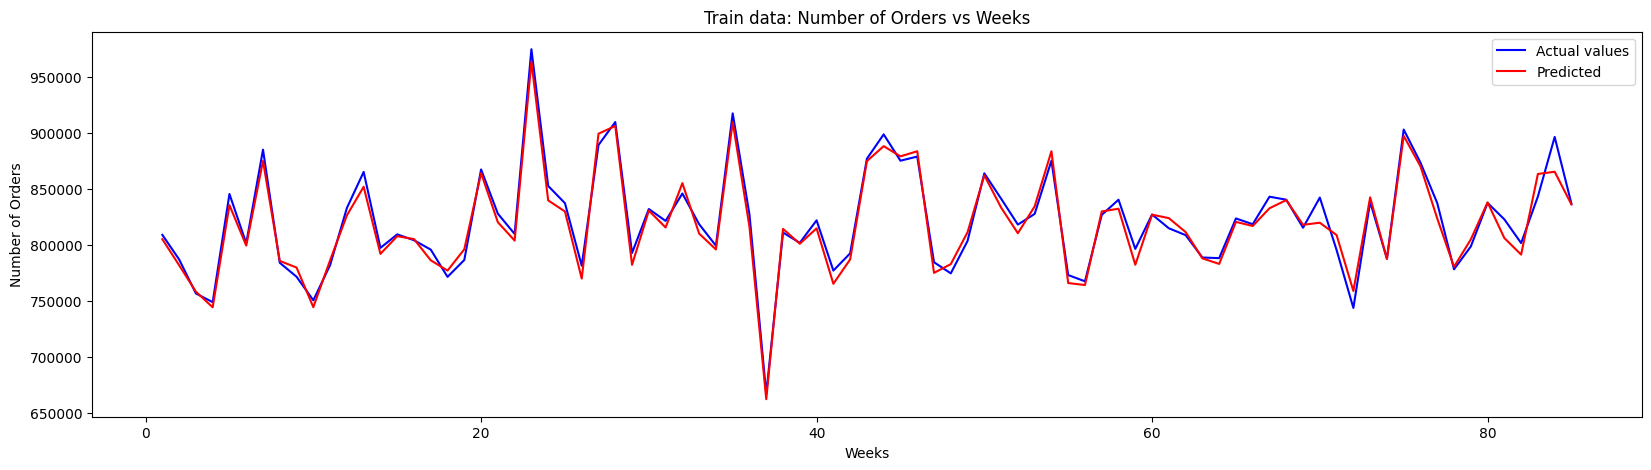

In [307]:
plt.figure(figsize=(20,5))
plt.plot(trainActual, color='blue', label='Actual values')
plt.plot(trainPred, color='red', label='Predicted')
plt.title('Train data: Number of Orders vs Weeks')
plt.xlabel('Weeks')
plt.ylabel('Number of Orders')
plt.legend(loc='best')
plt.show()

In [308]:
week_test = list(range(len(X_train)+1, len(X_train)+len(X_test)+1))
week_test

[86, 87, 88, 89, 90, 91, 92, 93, 94, 95]

In [309]:
testActual = pd.DataFrame({'Number of Orders': y_test[0]})
testActual.index = week_test

testPred = pd.DataFrame({'Number of Orders': test_pred[:,0]})
testPred.index = week_test

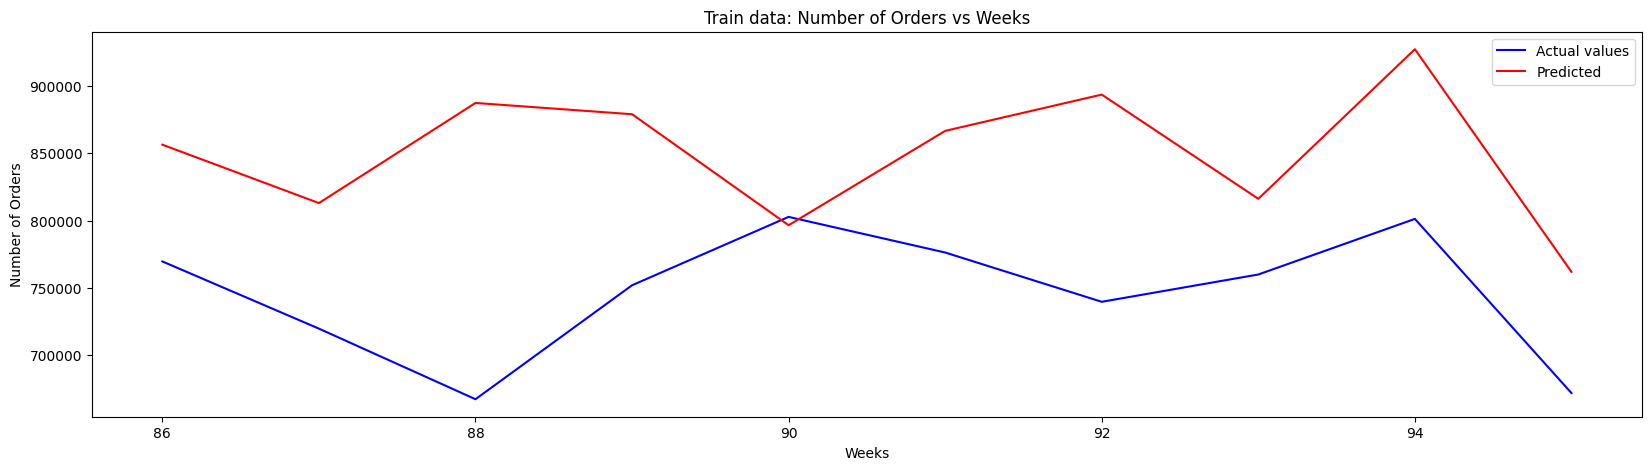

In [310]:
plt.figure(figsize=(20,5))
plt.plot(testActual, color='blue', label='Actual values')
plt.plot(testPred, color='red', label='Predicted')
plt.title('Train data: Number of Orders vs Weeks')
plt.xlabel('Weeks')
plt.ylabel('Number of Orders')
plt.legend(loc='best')
plt.show()